# Tratamento dos dados
Nesta etapa será realizado todo o tratamento dos dados, como fazer as transformações de tipo de variável, tratamento de missing, tratamento de outliers

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Importando os dados
df_vendas = pd.read_csv('../data/raw/sales.csv', index_col=0)
df_estoque_lvl = pd.read_csv('../data/raw/sensor_stock_levels.csv', index_col=0)
df_temperatura = pd.read_csv('../data/raw/sensor_storage_temperature.csv', index_col=0)

### Tratando o timestamp
Conforme visto na documentação, as tabelas podem ser unidas usando o timestamp, mas essa variável é medida de forma diferente nas tabelas, dificultando assim a mesclagem. Para resolver isso irei alterar o timestamp apenas para data e hora sem minutos, pois como definido no problema, os sensores realizarão medidas hora a hora.

Como a transformação funcionará:

06/05/2020 19:45:26 -> 06/05/2020 19:45
<br>
09/04/2019 16:10:08 -> 09/04/2019 16:10
<br>
19/10/2021 09:30:21 -> 19/10/2021 09:30

In [5]:
# Alterando a coluna timestamp
df_vendas['timestamp'] = pd.to_datetime(df_vendas.timestamp.str.slice(0, 16))
df_estoque_lvl['timestamp'] = pd.to_datetime(df_estoque_lvl.timestamp.str.slice(0, 16))
df_temperatura['timestamp'] = pd.to_datetime(df_temperatura.timestamp.str.slice(0, 16))

### Unindo as tabelas

In [6]:
# Unindo as tabelas e verificando o shape
df_vendas.merge(df_estoque_lvl, on = ['product_id', 'timestamp']).shape

(92, 11)

In [7]:
# Calculando a perda de dados
1 - df_vendas.merge(df_estoque_lvl, on = ['product_id', 'timestamp']).shape[0]/df_vendas.shape[0]

0.9882488184953379

Como a data e hora das vendas são diferentes das datas e hora das medições dos sensores, a união realizada pelo método **merge** está causando uma perda de cerca de 98% dos dados de vendas, o que é bastante.

Para solucionar esse problema, iremos unir os datasets manualmente utilizando o id e data, onde um produto será unido ao percentual de estoque anterior ao timestamp da venda.

In [8]:
# Criando listas vazias
lista_prcnt_estoque_futuro = []
lista_prcnt_estoque_passado = []

# Criando um loop para iterar sob cada indice
for num in range(0, df_vendas.shape[0]):
    
    # Obtendo o id do produto e o timestamp da venda
    timestamp_venda = df_vendas.iloc[num, 1]
    id_produto = df_vendas.iloc[num, 2]
    
    # Encontrando todos os registros de estoque do produto e adicionando o timestamp de venda a ela
    lista_filtrada = df_estoque_lvl.query(f"product_id == '{id_produto}'").timestamp.to_list()
    lista_filtrada.append(timestamp_venda)
    
    # Ordenando a lista 
    lista_ordenada = sorted(lista_filtrada)
    
    # Buscando o timestamp da ultima medição e da medição para prever
    try:
        timestamp_passado = lista_ordenada[lista_ordenada.index(timestamp_venda) - 1]
        registro = df_estoque_lvl.query(f"product_id == '{id_produto}' and timestamp == '{timestamp_passado}'")
        lvl_estoque_passado = registro.estimated_stock_pct.values[0]
        lista_prcnt_estoque_passado.append(lvl_estoque_passado)
    
    except:
        lista_prcnt_estoque_passado.append(np.nan)
        
    try:    
        timestamp_futuro = lista_ordenada[lista_ordenada.index(timestamp_venda) + 1]
        registro = df_estoque_lvl.query(f"product_id == '{id_produto}' and timestamp == '{timestamp_futuro}'")
        lvl_estoque_futuro = registro.estimated_stock_pct.values[0]
        lista_prcnt_estoque_futuro.append(lvl_estoque_futuro)
        
    except:
        lista_prcnt_estoque_futuro.append(np.nan)
        
df_vendas['lvl_estoque_past'] = lista_prcnt_estoque_passado
df_vendas['lvl_estoque_to_predict'] = lista_prcnt_estoque_futuro    

In [9]:
# Checando a próxima tabela
df_temperatura.sort_values('timestamp')

,id,timestamp,temperature
14130,d451bd29-d3d2-42a1-b228-150b5ba4d664,2022-03-01 09:00:00,-1.93
15982,148a729c-0926-4f8b-9bda-f214d0f67b8d,2022-03-01 09:00:00,1.00
5593,151f56ba-b488-4297-b503-f5b50fee2be7,2022-03-01 09:00:00,-2.10
6061,d050c5f2-0ffc-49ee-b8a0-beef559f5b29,2022-03-01 09:00:00,1.85
7495,fb02fefe-da3a-4e1d-98be-f6523bc6fac6,2022-03-01 09:00:00,-2.45
...,...,...,...
14453,4a978e83-4b25-4648-85c5-f354e015fe4d,2022-03-07 19:59:00,-2.91
7902,36a6cdb6-b344-4bfb-ab21-4f33ffe064e0,2022-03-07 19:59:00,0.71
18379,d502a503-33ec-49c8-97e7-792aa6ce3421,2022-03-07 19:59:00,-2.98
12147,33313da5-9999-4aef-a595-63ad14fe9468,2022-03-07 19:59:00,0.55


Aqui a nossa abordagem será alterada, pois ao contrário da tabela de estoque, onde tínhamos valores únicos por timestamp devido a diferenciação proporcionada ID, não possuímos a mesma diferenciação aqui, onde cada timestamp possui vários valores diferentes de temperatura associados a ele.

Sendo assim, irei agrupar o timestamp e usarei a coluna de temperatura par calcular algumas estatísticas para cada horário, como média, desvio padrão, mediana, variância, etc. É necessário valores únicos para uma união sem perda de valor entre as tabelas.

In [10]:
# Computando estatísticas e resetando o index
df_temperatura = df_temperatura.groupby('timestamp').temperature.agg(['mean', 'median', 'min', 'max'])
df_temperatura = df_temperatura.reset_index()

In [11]:
# Unindo as  e salvando os dados
df_unido = df_vendas.merge(df_temperatura, on = 'timestamp')
df_unido.to_csv('../data/interim/dados_unidos.csv')

In [12]:
# Checando o resultado da união
df_unido.head()

,transaction_id,timestamp,product_id,category,customer_type,unit_price,quantity,total,payment_type,lvl_estoque_past,lvl_estoque_to_predict,mean,median,min,max
0,a1c82654-c52c-45b3-8ce8-4c2a1efe63ed,2022-03-02 09:51:00,3bc6c1ea-0198-46de-9ffd-514ae3338713,fruit,gold,3.99,2,7.98,e-wallet,0.23,0.37,-1.05,-2.24,-2.89,1.67
1,09125d95-599d-42ec-86d6-14114b9b0a2d,2022-03-02 09:51:00,14736243-d346-438f-9535-d80fcb9f3882,fruit,premium,1.49,1,1.49,credit card,0.54,0.33,-1.05,-2.24,-2.89,1.67
2,d61fa000-dff4-45c0-b4f6-9530c047e0ff,2022-03-02 09:51:00,7f5e86e6-f06f-45f6-bf44-27b095c9ad1d,fruit,non-member,4.49,4,17.96,credit card,0.71,0.37,-1.05,-2.24,-2.89,1.67
3,6e02d286-ee8f-4e3c-9945-f358999b2d37,2022-03-02 09:51:00,7f6922e9-b858-41c6-8765-9750bc5e8a86,refrigerated items,gold,5.99,1,5.99,credit card,0.54,0.52,-1.05,-2.24,-2.89,1.67
4,257ce545-3c86-44e9-8c73-2c2d231bee71,2022-03-02 09:51:00,049b2171-0eeb-4a3e-bf98-0c290c7821da,canned foods,gold,2.49,1,2.49,e-wallet,0.33,0.69,-1.05,-2.24,-2.89,1.67


### Criando novas features
Agora que já possuímos um dataset completo, vou criar mais algumas feature a partir dos dados de tempo e dropar os id's.

In [13]:
# Buscando o dia da semana
df_unido['day_of_week'] = df_unido.timestamp.dt.weekday

# Buscando se é final de semana
df_unido['is_weekend'] = df_unido.day_of_week.apply(lambda day: 'yes' if day > 4 else 'no')

# Buscando a hora e turno
df_unido['hour'] = df_unido.timestamp.dt.hour
df_unido['turn'] = df_unido.hour.apply(lambda hour: 'morning' if hour < 12 else ('afternoon' if 12 <= hour < 18 else 'night'))

In [14]:
df_unido['hour'] = df_unido.timestamp.dt.hour
df_unido['turn'] = df_unido.hour.apply(lambda hour: 'morning' if hour < 12 else ('afternoon' if 12 <= hour < 18 else 'night'))

### Investigando Outliers
Como vimos na etapa de EDA, existem alguns outliers nas colunas **total** e **unit_price**.

In [15]:
# Calculando os quartis e o IQR
q1 = np.quantile(df_unido.total, 0.25)
q3 = np.quantile(df_unido.total, 0.75)
iqr = q3 - q1

#Separando os dados sem e com outliers
dados_com_outliers = df_unido.query(f"total > {q3 + 1.5 * iqr}")
dados_sem_outliers = df_unido.query(f"total < {q3 + 1.5 * iqr}")

In [16]:
# Verificando a quantidade
dados_com_outliers.shape[0]

300

(array([1903., 1516., 1242.,  800.,  609.,  496.,  394.,  252.,  142.,
         153.]),
 array([ 0.19 ,  6.247, 12.304, 18.361, 24.418, 30.475, 36.532, 42.589,
        48.646, 54.703, 60.76 ]),
 <BarContainer object of 10 artists>)

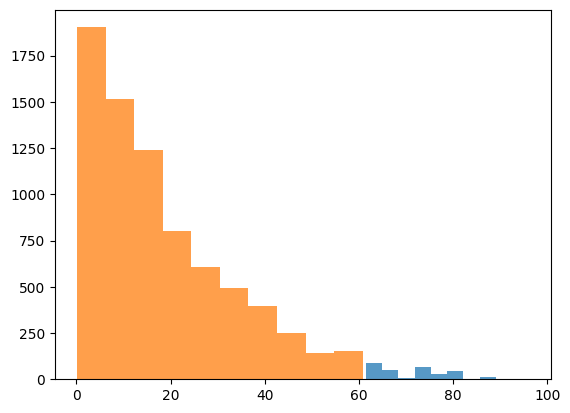

In [17]:
# Verificando as distribuições
plt.hist(dados_com_outliers.total, alpha = 0.75)
plt.hist(dados_sem_outliers.total, alpha = 0.75)

 A distribuição dos dados é relativamente próxima, não existindo outliers discrepantes.

In [18]:
print(f"O preço médio por unidade dos dados sem outliers é de: {dados_sem_outliers.unit_price.mean()}")
print(f"O preço médio por unidade dos dados com outliers é de: {dados_com_outliers.unit_price.mean()}")


O preço médio por unidade dos dados sem outliers é de: 7.389094178766484
O preço médio por unidade dos dados com outliers é de: 18.545


 diferença no preço é relativamente alta.

In [19]:
print(f"A quantidade média de itens comprados nos dados sem outliers é de: {dados_sem_outliers.quantity.mean()}")
print(f"A quantidade média de itens comprados nos dados com outliers é de: {dados_com_outliers.quantity.mean()}")

A quantidade média de itens comprados nos dados sem outliers é de: 2.4457173304915414
A quantidade média de itens comprados nos dados com outliers é de: 3.88


A quantidade de itens comprados também possui uma diferença significativa.

In [20]:
# Calculando os quartis e o IQR
q1 = np.quantile(df_unido.unit_price, 0.25)
q3 = np.quantile(df_unido.unit_price, 0.75)
iqr = q3 - q1

#Separando os dados sem e com outliers
dados_com_outliers = df_unido.query(f"unit_price > {q3 + 1.5 * iqr}")
dados_sem_outliers = df_unido.query(f"unit_price < {q3 + 1.5 * iqr}")

In [21]:
# Verificando a quantidade
dados_com_outliers.shape[0]

31

(array([1273., 1188., 1141., 1227.,  894.,  609.,  391.,  468.,  272.,
         296.]),
 array([ 0.19,  2.27,  4.35,  6.43,  8.51, 10.59, 12.67, 14.75, 16.83,
        18.91, 20.99]),
 <BarContainer object of 10 artists>)

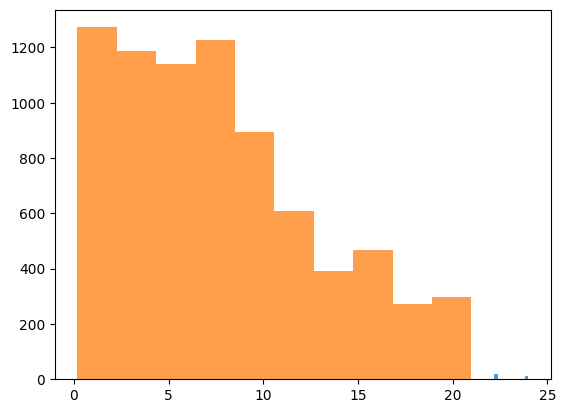

In [22]:
# Verificando as distribuições
plt.hist(dados_com_outliers.unit_price, alpha = 0.75)
plt.hist(dados_sem_outliers.unit_price, alpha = 0.75)

Levando em consideração que as unidades mais caras estão bem próximas das não consideradas outliers, e que compras com outliers são aquelas que possuem os produtos mais caros e que são levados em uma quantidade próxima ao máximo registrado, posso concluir que os outliers são naturais. Removê-los ou tratar como uma inconsistência atrapalharia no aprendizado do modelo.

### Dropando colunas
Nesta etapa irei deletar algumas colunas que não agregam valor, como id's e timestamp.

In [23]:
# Excluindo as colunas
df_unido = df_unido.drop(columns=['transaction_id', 'product_id', 'timestamp'])

In [24]:
# Salvando os dados
df_unido.to_csv('../data/interim/dados_para_treino.csv')

Levando em conta que não temos mais mais tratamentos para aplicar, não possuímos valores missing e nem duplicatas ou inconsistências, irei utilizar a última versão do dataset para construir um modelo de Machine Learning. Entretanto, como novas variáveis foram criadas, irei checar as relações e correlações em busca de insights.

### Checando correlações e relacionamentos

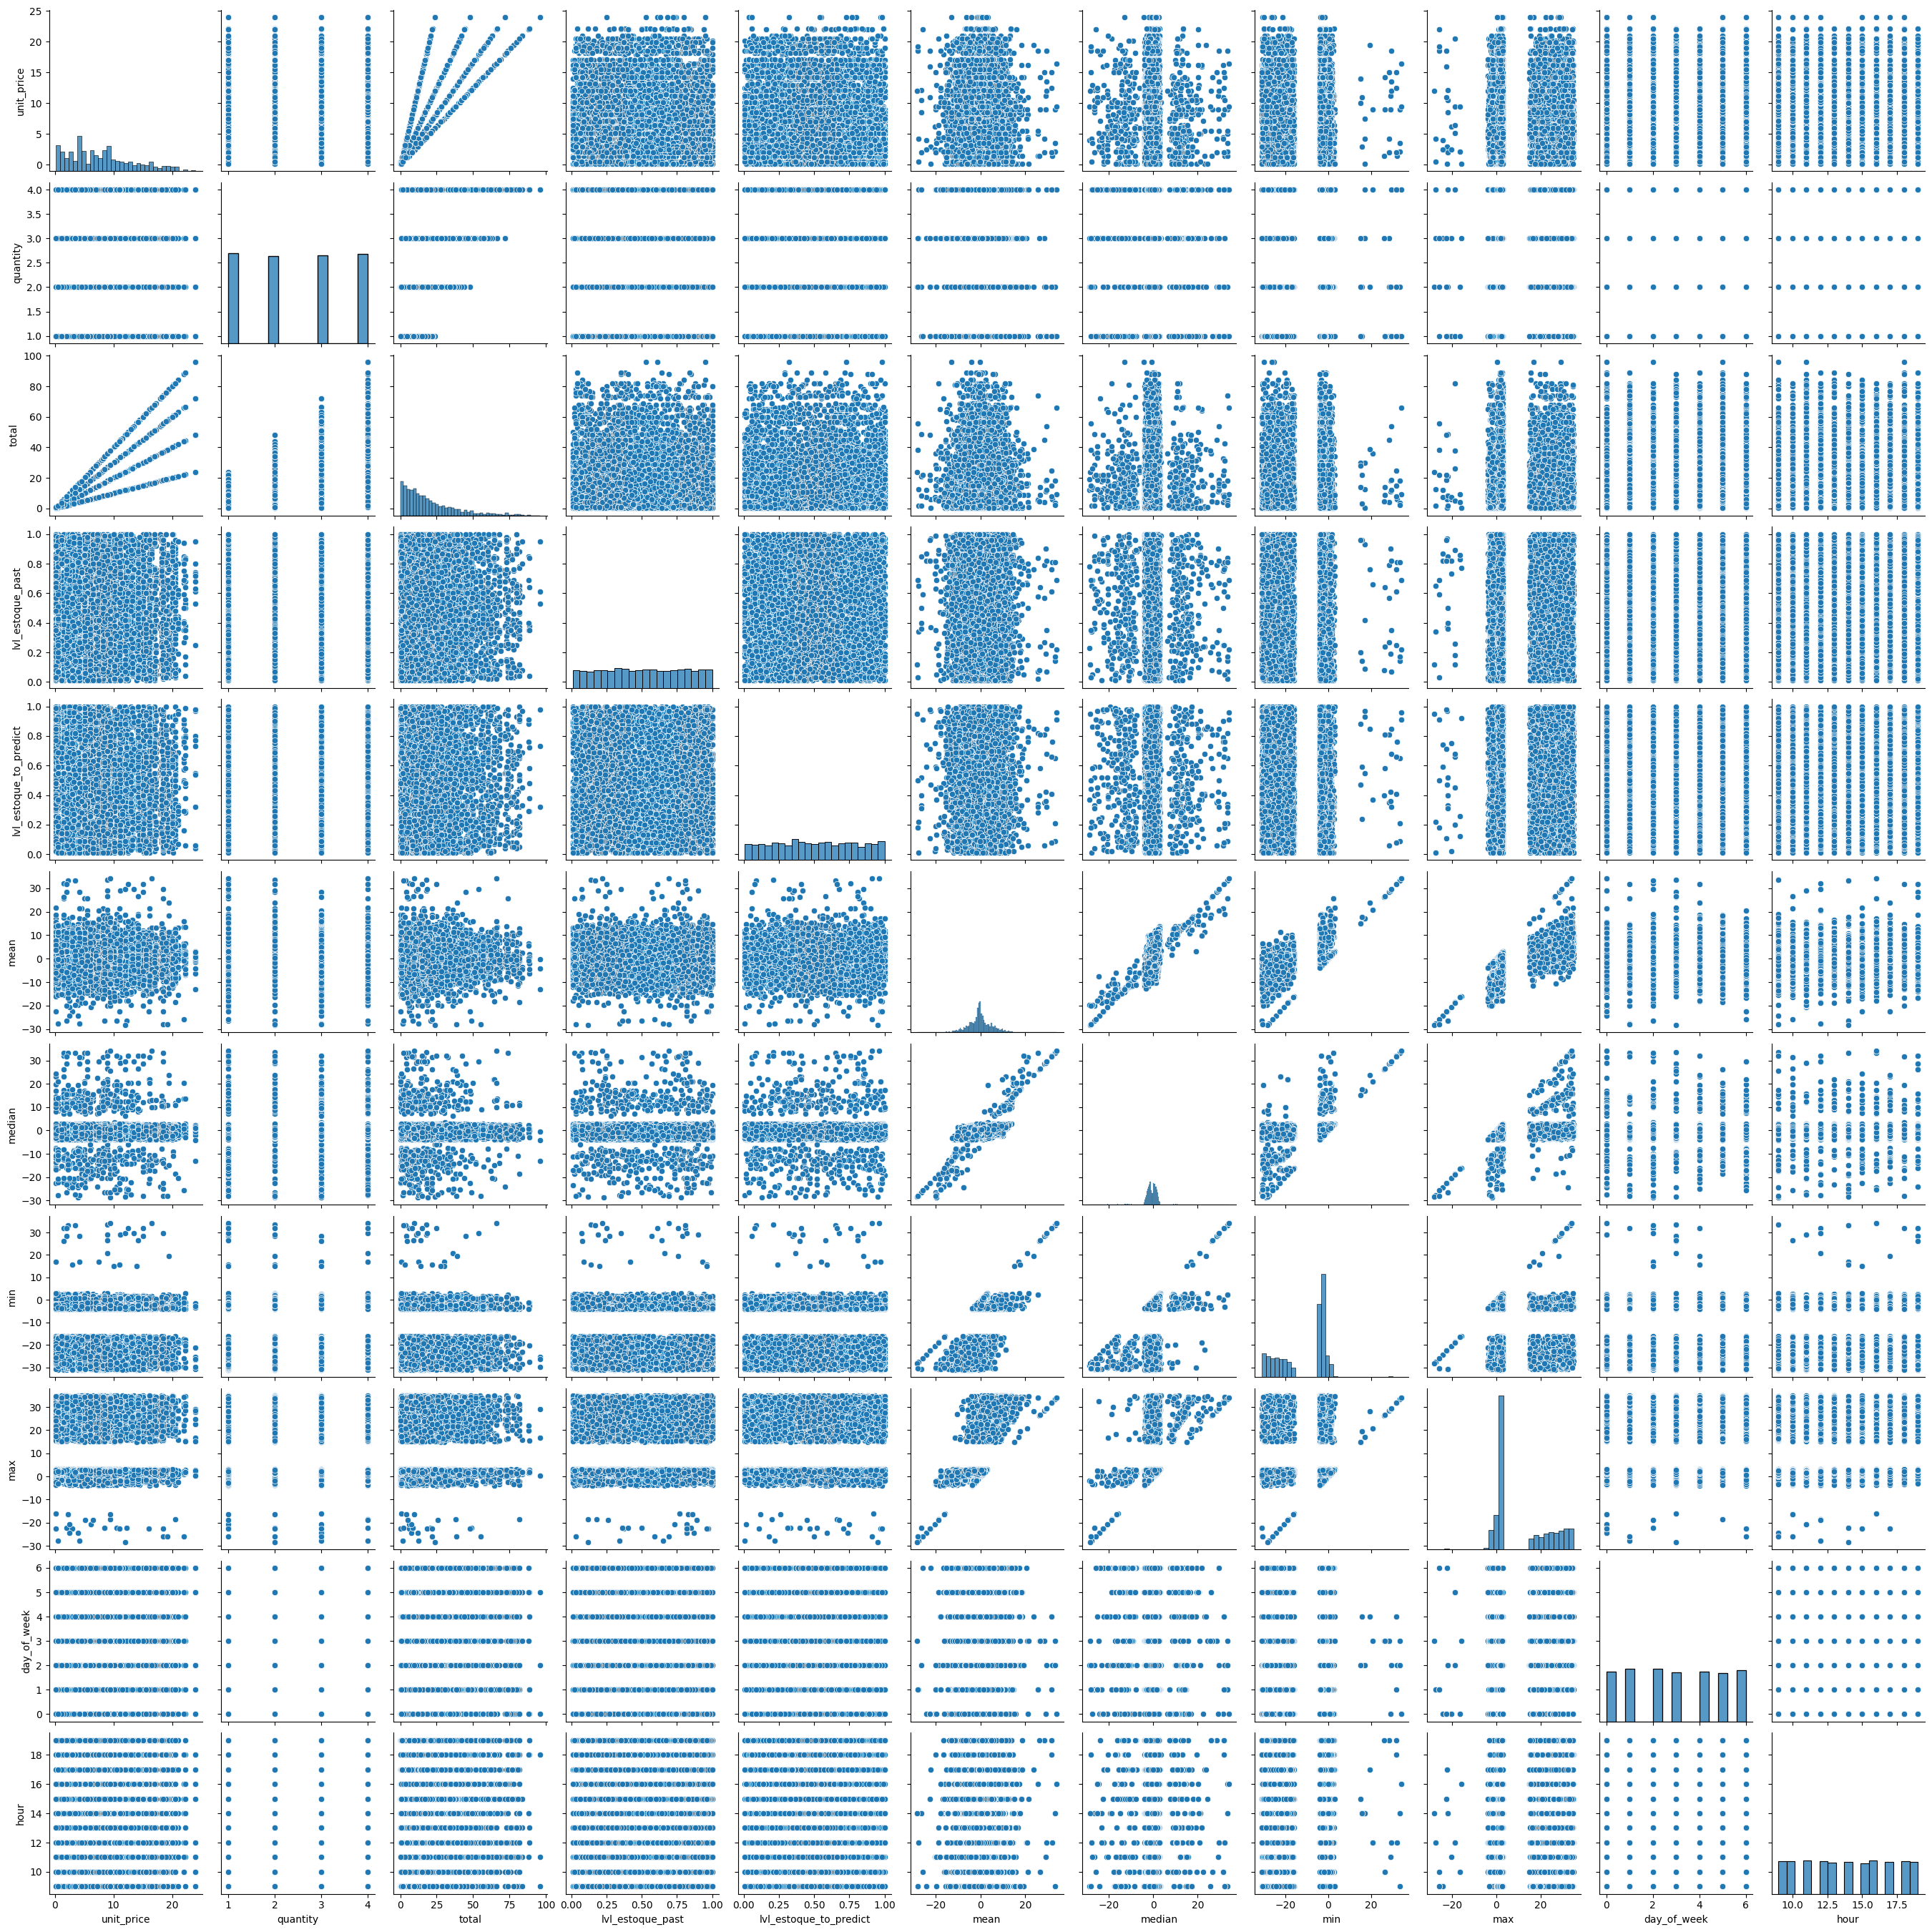

In [25]:
# Checando as relações
sns.pairplot(df_unido)

<Axes: >

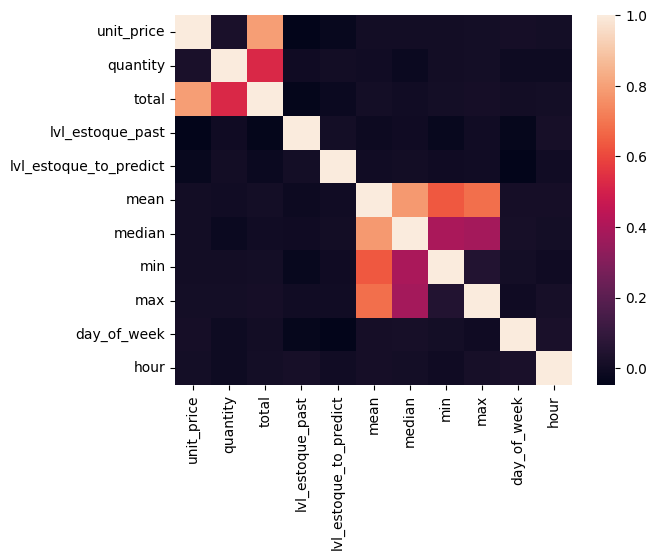

In [28]:
# Checando as correlações
sns.heatmap(df_unido.corr(numeric_only=True))